In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# call library
# kaggle 기준 해당 .ipynb파일이 작동하는 것을 확인했습니다. 만약, 로컬환경에서 실행할 예정이라면, 아래 링크를 활용해서 설치해주세요.
# https://pytorch.org/get-started/previous-versions/
# 로컬에서 테스트된 환경은 다음과 같습니다. pytorch 2.0.0 with python=3.9, cuda=11.7, cudnn=8.0, torchvision==0.15.0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import roc_curve, auc

import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # CUDA 사용 시
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # CuDNN 재현성을 위해 설정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [4]:
# hyperparameter setting
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
EPOCH = 5
BATCH_SIZE = 4
LEARNING_RATE = 0.005

# Computational device
# Device will be set to GPU if it is available.(you should install valid Pytorch version with CUDA. Otherwise, it will be computed using CPU)
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [5]:
# Fashion MNIST dataset
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# dataset detail
# https://github.com/zalandoresearch/fashion-mnist
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)


# Set for data loader
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
SELECT_NORMAL = 2 # Set 2 class as train dataset.
trainset.data = trainset.data[trainset.targets == SELECT_NORMAL]
trainset.targets = trainset.targets[trainset.targets == SELECT_NORMAL]

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

test_label = [2,4,6] # Define actual test class that we use
actual_testdata = torch.isin(testset.targets, torch.tensor(test_label))
testset.data = testset.data[actual_testdata]
testset.targets = testset.targets[actual_testdata]

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = 1,
    shuffle     = False,
    num_workers = 2
)


# 시각화용 view_data 준비 (각 클래스당 3개씩 샘플)
view_data = []
for label in test_label:
    # 해당 클래스의 첫 3개 샘플 선택, 데이터셋 구조에 따라 [:3]로 3개 샘플 선택
    samples = testset.data[testset.targets == label][:3]  # [3, 28, 28]
    samples = samples.unsqueeze(1)  # 채널 차원 추가, [3, 1, 28, 28]
    view_data.append(samples)
view_data = torch.cat(view_data, dim=0).float() / 255.


100%|██████████| 26.4M/26.4M [00:01<00:00, 19.0MB/s]


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 296kB/s]


Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.54MB/s]


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 13.9MB/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [6]:
# 시각화용 view_data 준비 (각 클래스당 3개씩 샘플)
view_data = []
for label in test_label:
    # 해당 클래스의 첫 3개 샘플 선택, 데이터셋 구조에 따라 [:3]로 3개 샘플 선택
    samples = testset.data[testset.targets == label][:3]  # [3, 28, 28]
    samples = samples.unsqueeze(1)  # 채널 차원 추가, [3, 1, 28, 28]
    view_data.append(samples)
view_data = torch.cat(view_data, dim=0).float() / 255.

In [19]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import optuna
import pandas as pd
from sklearn.metrics import accuracy_score, roc_curve, auc

#############################################
# 재현성 확보를 위한 시드 고정 함수
#############################################
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

#############################################
# 기본 설정 및 시각화용 데이터 준비
#############################################
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-3
EPOCH = 10            # 학습 epoch 10으로 고정
BATCH_SIZE = 64
test_label = [2, 4, 6]
SELECT_NORMAL = 2     # 정상: 클래스 2

# testset 및 train_loader, test_loader는 미리 정의되어 있다고 가정

# 시각화용 데이터 (각 클래스당 3개 샘플)
view_data = []
for label in test_label:
    samples = testset.data[testset.targets == label][:3]
    samples = samples.unsqueeze(1)  # [3, 1, 28, 28]
    view_data.append(samples)
view_data = torch.cat(view_data, dim=0).float() / 255.

#############################################
# EnhancedMemAE 모델 (메모리 기반 Autoencoder)
#############################################
class EnhancedMemAE_Arch(nn.Module):
    def __init__(self, mem_dim=200, fea_dim=128, channel_mult=1.0, shrink_thres=0.0, 
                 input_noise_std=0.1, latent_noise_std=0.2):
        """
        mem_dim: Memory module 크기 (정상 특징을 기억)
        fea_dim: Encoder 마지막 완전 연결층 출력 차원 (latent vector 차원)
        channel_mult: 기본 채널 수에 곱할 인자 (예: 1.0이면 그대로, 0.8이면 축소, 2.0이면 확대)
        shrink_thres: memory attention hard-shrink threshold (현재 미사용)
        input_noise_std: 입력 노이즈 표준편차
        latent_noise_std: latent noise 표준편차
        """
        super(EnhancedMemAE_Arch, self).__init__()
        base_c1 = int(32 * channel_mult)
        base_c2 = int(64 * channel_mult)
        
        # Encoder: 28x28 → [B, base_c1, 28,28] → [B, base_c1, 14,14] → [B, base_c2, 7,7]
        self.encoder = nn.Sequential(
            nn.Conv2d(1, base_c1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(base_c1, base_c2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(base_c2 * 7 * 7, fea_dim)
        self.relu = nn.ReLU()
        
        # Memory module: [mem_dim x fea_dim]
        self.memory = nn.Parameter(torch.randn(mem_dim, fea_dim))
        self.shrink_thres = shrink_thres  # 미사용
        
        # Decoder: latent vector → FC → reshape → ConvTranspose
        self.fc_dec = nn.Linear(fea_dim, base_c2 * 7 * 7)
        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (base_c2, 7, 7)),
            nn.ConvTranspose2d(base_c2, base_c1, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(base_c1, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
        self.input_noise_std = input_noise_std
        self.latent_noise_std = latent_noise_std

    def forward(self, x):
        if self.training:
            x = x + torch.randn_like(x) * self.input_noise_std
            x = torch.clamp(x, 0.0, 1.0)
        conv_out = self.encoder(x)           # [B, base_c2, 7, 7]
        flat = self.flatten(conv_out)        # [B, base_c2 * 7 * 7]
        z = self.relu(self.fc_enc(flat))     # [B, fea_dim]
        
        # Memory attention
        mem_weight = F.softmax(torch.matmul(z, self.memory.t()), dim=1)  # [B, mem_dim]
        z_hat = torch.matmul(mem_weight, self.memory)  # [B, fea_dim]
        if self.training:
            z_hat = z_hat + torch.randn_like(z_hat) * self.latent_noise_std
        
        dec_flat = self.fc_dec(z_hat)          # [B, base_c2 * 7 * 7]
        out = self.decoder_conv(dec_flat)      # [B, 1, 28, 28]
        return out, z, z_hat, mem_weight

#############################################
# Loss 함수 구성 및 Feature Extractor
#############################################
def weighted_mse_with_sigma(pred, target, sigma):
    B, C, H, W = pred.shape
    device = pred.device
    y = torch.arange(H, dtype=torch.float32, device=device)
    x = torch.arange(W, dtype=torch.float32, device=device)
    grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
    center_y, center_x = H/2, W/2
    weight = torch.exp(-((grid_x - center_x)**2 + (grid_y - center_y)**2) / (2 * sigma**2))  # ✅ 가우시안에서 sigma 적용
    weight = weight.unsqueeze(0).unsqueeze(0)
    return (weight * (pred - target)**2).mean()


def sobel_filter(img):
    kernel_x = torch.tensor([[-1, 0, 1],
                              [-2, 0, 2],
                              [-1, 0, 1]], dtype=torch.float32, device=img.device).view(1,1,3,3)
    kernel_y = torch.tensor([[-1,-2,-1],
                              [0, 0, 0],
                              [1, 2, 1]], dtype=torch.float32, device=img.device).view(1,1,3,3)
    edge_x = F.conv2d(img, kernel_x, padding=1)
    edge_y = F.conv2d(img, kernel_y, padding=1)
    return torch.sqrt(edge_x**2 + edge_y**2 + 1e-6)

def ssim_loss(pred, target, C1=0.01**2, C2=0.03**2):
    mu_x = F.avg_pool2d(pred, 3, stride=1, padding=1)
    mu_y = F.avg_pool2d(target, 3, stride=1, padding=1)
    sigma_x = F.avg_pool2d(pred**2, 3, stride=1, padding=1) - mu_x**2
    sigma_y = F.avg_pool2d(target**2, 3, stride=1, padding=1) - mu_y**2
    sigma_xy = F.avg_pool2d(pred*target, 3, stride=1, padding=1) - mu_x*mu_y
    SSIM = ((2*mu_x*mu_y+C1)*(2*sigma_xy+C2)) / ((mu_x**2+mu_y**2+C1)*(sigma_x+sigma_y+C2))
    return torch.clamp((1-SSIM)/2, 0, 1).mean()

def ms_ssim_loss(pred, target, levels=3):
    msssim_values = []
    weight = 1.0
    total_weight = 0
    current_pred = pred
    current_target = target
    for i in range(levels):
        ssim_val = ssim_loss(current_pred, current_target)
        msssim_values.append(weight * ssim_val)
        total_weight += weight
        weight /= 2.0
        current_pred = F.avg_pool2d(current_pred,2)
        current_target = F.avg_pool2d(current_target,2)
    return sum(msssim_values)/total_weight

def perceptual_loss(pred, target, feature_extractor, layers=['layer1','layer2']):
    pred_feats = feature_extractor(pred)
    target_feats = feature_extractor(target)
    loss = 0
    for key in layers:
        loss += F.mse_loss(pred_feats[key], target_feats[key])
    return loss/len(layers)

def latent_loss(z, c):
    return ((z-c)**2).mean()

def compute_latent_center(model, train_loader):
    model.eval()
    all_z = []
    with torch.no_grad():
        for x, _ in train_loader:
            x = x.to(DEVICE)
            _, z, _, _ = model(x)
            all_z.append(z)
    all_z = torch.cat(all_z, dim=0)
    return all_z.mean(dim=0)



# 전역 latent_center: 모델의 latent 차원(fea_dim)에 맞춰 objective 함수에서 설정
latent_center = None

def improved_attn_loss(pred, target, feature_extractor, z, 
                       w_mse=1.0, w_edge=0.2, w_ms_ssim=1.4,
                       w_perc=1.3, w_latent=0.01, sigma=2.8, delta=0.0):
    wmse = weighted_mse_with_sigma(pred, target, sigma)  # ✅ sigma 인자 사용
    edge_loss = F.mse_loss(sobel_filter(pred), sobel_filter(target))
    ms_ssim = ms_ssim_loss(pred, target)
    # perc_loss = perceptual_loss(pred, target, feature_extractor)
    lat_loss = latent_loss(z, latent_center)
    # return wmse + w_edge*edge_loss + w_ms_ssim*ms_ssim + w_perc*perc_loss + w_latent*lat_loss + delta
    return wmse + w_edge*edge_loss +  w_ms_ssim*ms_ssim +  w_latent*lat_loss + delta


class SimpleFeatureExtractor(nn.Module):
    def __init__(self):
        super(SimpleFeatureExtractor, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        feat1 = self.layer1(x)
        feat2 = self.layer2(feat1)
        return {'layer1': feat1, 'layer2': feat2}

feature_extractor = SimpleFeatureExtractor().to(DEVICE)


In [21]:
####################################
# 학습, 테스트, 평가 함수들
####################################

def train_attn(model, train_loader, optimizer, device, feature_extractor, loss_params):
    model.train()
    total_loss = 0
    for step, (x, _) in enumerate(train_loader):
        x = x.to(device)
        recon, z, z_hat, mem_weight = model(x)
        loss = improved_attn_loss(recon, x, feature_extractor, z,
                                  w_mse=1.0,
                                  w_edge=loss_params['w_edge'],
                                  w_ms_ssim=loss_params['w_ms_ssim'],
                                  w_perc=loss_params['w_perc'],
                                  w_latent=loss_params['w_latent'],
                                  sigma=loss_params['sigma'],
                                  delta=0.0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if step % 600 == 0:
            print(f"Step {step}, Loss: {loss.item():.4f}")
    return total_loss / len(train_loader)

def test_plot(model):
    model.eval()
    test_x = view_data.to(DEVICE)
    with torch.no_grad():
        pred, _, _, _ = model(test_x)
    cols = test_x.shape[0]
    fig, axes = plt.subplots(2, cols, figsize=(cols,2))
    for i in range(cols):
        axes[0,i].imshow(test_x[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0,i].axis('off')
        axes[1,i].imshow(pred[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1,i].axis('off')
    plt.tight_layout()
    plt.show()

def compute_anomaly_scores(model, test_loader, device, feature_extractor, loss_params, gamma=0.5, SELECT_NORMAL=2):
    model.eval()
    dic_loss = {'id':[], 'label':[], 'score':[]}
    with torch.no_grad():
        for step, (x, labels) in enumerate(test_loader):
            x = x.to(device)
            pred, z, _, _ = model(x)
            B = x.size(0)
            for i in range(B):
                sample_x = x[i:i+1]
                sample_pred = pred[i:i+1]
                sample_z = z[i:i+1]
                sample_loss = improved_attn_loss(sample_pred, sample_x, feature_extractor, sample_z,
                                                  w_mse=1.0,
                                                  w_edge=loss_params['w_edge'],
                                                  w_ms_ssim=loss_params['w_ms_ssim'],
                                                  w_perc=0, #loss_params['w_perc'],
                                                  w_latent=loss_params['w_latent'],
                                                  sigma=loss_params['sigma'],
                                                  delta=0.0)
                sample_id = step * B + i
                dic_loss['id'].append(sample_id)
                dic_loss['label'].append(1 if labels[i].item()==SELECT_NORMAL else 0)
                dic_loss['score'].append(sample_loss.item())
    return dic_loss

####################################
# 모델 구조 Hyperparameter를 고정하고, Loss hyperparameter 탐색 (Optuna)
####################################

# 여기서는 모델 구조는 Trial 20에서 얻은 최적값으로 고정합니다.
FIXED_ARCH_PARAMS = {
    "mem_dim": 256,
    "fea_dim": 256,
    "channel_mult": 1.0,
    "input_noise_std": 0.0894,
    "latent_noise_std": 0.1931
}

def objective_loss(trial):
    # Loss hyperparameter 탐색 범위 (기본값 주변)
    w_edge = trial.suggest_float("w_edge", 0.18, 0.23)
    w_ms_ssim = trial.suggest_float("w_ms_ssim", 1.2, 1.6)
    # w_perc = trial.suggest_float("w_perc", 1.2, 1.6)
    w_latent = trial.suggest_float("w_latent", 0.005, 0.015)
    sigma = trial.suggest_float("sigma", 2.0, 6.0)
    
    loss_params = {
        'w_edge': w_edge,
        'w_ms_ssim': w_ms_ssim,
        'w_perc': 0,
        'w_latent': w_latent,
        'sigma': sigma
    }
    
    # 모델 구조는 고정된 값으로 초기화
    model = EnhancedMemAE_Arch(mem_dim=FIXED_ARCH_PARAMS["mem_dim"],
                               fea_dim=FIXED_ARCH_PARAMS["fea_dim"],
                               channel_mult=FIXED_ARCH_PARAMS["channel_mult"],
                               shrink_thres=0.0,
                               input_noise_std=FIXED_ARCH_PARAMS["input_noise_std"],
                               latent_noise_std=FIXED_ARCH_PARAMS["latent_noise_std"]).to(DEVICE)
    
    global latent_center
    latent_center = torch.full((FIXED_ARCH_PARAMS["fea_dim"],), 0.5, device=DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCH)
    
    for epoch in range(1, EPOCH + 1):
        _ = train_attn(model, train_loader, optimizer, DEVICE, feature_extractor, loss_params)
        scheduler.step()
    
    dic_loss = compute_anomaly_scores(model, test_loader, DEVICE, feature_extractor, loss_params, gamma=0.5, SELECT_NORMAL=SELECT_NORMAL)
    arr_label = np.array(dic_loss['label'])
    arr_score = np.array(dic_loss['score'])
    
    thresholds = np.linspace(arr_score.min(), arr_score.max(), num=300)
    best_acc = 0.0
    for thresh in thresholds:
        preds = np.where(arr_score > thresh, 0, 1)
        acc = accuracy_score(arr_label, preds)
        if acc > best_acc:
            best_acc = acc
    # print(f"Trial {trial.number}: Loss HP -> w_edge={w_edge:.4f}, w_ms_ssim={w_ms_ssim:.4f}, w_perc={w_perc:.4f}, w_latent={w_latent:.4f} | Accuracy = {best_acc:.4f}")
    print(f"Trial {trial.number}: Loss HP ->  w_edge={w_edge:.4f}, w_ms_ssim={w_ms_ssim:.4f}, w_latent={w_latent:.4f} | Accuracy = {best_acc:.4f}")
    return best_acc

study_loss = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study_loss.optimize(objective_loss, n_trials=5)

print("Best Loss Hyperparameters:")
print(f"  Accuracy: {study_loss.best_trial.value:.4f}")
for key, value in study_loss.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-04-16 04:52:43,302] A new study created in memory with name: no-name-ea3a6da2-f004-4b98-8c1f-a0eb109bad0e


Step 0, Loss: 1.0272
Step 600, Loss: 0.6335
Step 1200, Loss: 0.6436
Step 0, Loss: 0.5080
Step 600, Loss: 0.3579
Step 1200, Loss: 0.3386
Step 0, Loss: 0.4674
Step 600, Loss: 0.3153
Step 1200, Loss: 0.3770
Step 0, Loss: 0.3870
Step 600, Loss: 0.3525
Step 1200, Loss: 0.3392
Step 0, Loss: 0.2568
Step 600, Loss: 0.2948
Step 1200, Loss: 0.3548
Step 0, Loss: 0.3213
Step 600, Loss: 0.5638
Step 1200, Loss: 0.2800
Step 0, Loss: 0.3231
Step 600, Loss: 0.3023
Step 1200, Loss: 0.4103
Step 0, Loss: 0.4081
Step 600, Loss: 0.3703
Step 1200, Loss: 0.4813
Step 0, Loss: 0.2749
Step 600, Loss: 0.3209
Step 1200, Loss: 0.2155
Step 0, Loss: 0.1995
Step 600, Loss: 0.2978
Step 1200, Loss: 0.2400


[I 2025-04-16 04:55:10,558] Trial 0 finished with value: 0.7433333333333333 and parameters: {'w_edge': 0.1987270059423681, 'w_ms_ssim': 1.5802857225639666, 'w_latent': 0.012319939418114049, 'sigma': 4.394633936788146}. Best is trial 0 with value: 0.7433333333333333.


Trial 0: Loss HP ->  w_edge=0.1987, w_ms_ssim=1.5803, w_latent=0.0123 | Accuracy = 0.7433
Step 0, Loss: 1.0623
Step 600, Loss: 0.4582
Step 1200, Loss: 0.5046
Step 0, Loss: 0.5305
Step 600, Loss: 0.3993
Step 1200, Loss: 0.3536
Step 0, Loss: 0.3130
Step 600, Loss: 0.3384
Step 1200, Loss: 0.2725
Step 0, Loss: 0.2248
Step 600, Loss: 0.3219
Step 1200, Loss: 0.1688
Step 0, Loss: 0.2825
Step 600, Loss: 0.1865
Step 1200, Loss: 0.1845
Step 0, Loss: 0.3632
Step 600, Loss: 0.2433
Step 1200, Loss: 0.2108
Step 0, Loss: 0.1758
Step 600, Loss: 0.3229
Step 1200, Loss: 0.1460
Step 0, Loss: 0.1575
Step 600, Loss: 0.3341
Step 1200, Loss: 0.2225
Step 0, Loss: 0.2141
Step 600, Loss: 0.1638
Step 1200, Loss: 0.2038
Step 0, Loss: 0.1480
Step 600, Loss: 0.1668
Step 1200, Loss: 0.2924


[I 2025-04-16 04:57:37,566] Trial 1 finished with value: 0.7303333333333333 and parameters: {'w_edge': 0.18780093202212184, 'w_ms_ssim': 1.262397808134481, 'w_latent': 0.005580836121681995, 'sigma': 5.46470458309974}. Best is trial 0 with value: 0.7433333333333333.


Trial 1: Loss HP ->  w_edge=0.1878, w_ms_ssim=1.2624, w_latent=0.0056 | Accuracy = 0.7303
Step 0, Loss: 0.8975
Step 600, Loss: 0.5385
Step 1200, Loss: 0.4627
Step 0, Loss: 0.5580
Step 600, Loss: 0.5440
Step 1200, Loss: 0.6543
Step 0, Loss: 0.4466
Step 600, Loss: 0.7204
Step 1200, Loss: 0.5072
Step 0, Loss: 0.4775
Step 600, Loss: 0.5233
Step 1200, Loss: 0.4573
Step 0, Loss: 0.5198
Step 600, Loss: 0.6386
Step 1200, Loss: 0.5760
Step 0, Loss: 0.6832
Step 600, Loss: 0.5872
Step 1200, Loss: 0.6713
Step 0, Loss: 0.3849
Step 600, Loss: 0.5760
Step 1200, Loss: 0.7199
Step 0, Loss: 0.6844
Step 600, Loss: 0.5713
Step 1200, Loss: 0.5216
Step 0, Loss: 0.5903
Step 600, Loss: 0.5720
Step 1200, Loss: 0.5761
Step 0, Loss: 0.5602
Step 600, Loss: 0.5777
Step 1200, Loss: 0.5958


[I 2025-04-16 05:00:03,962] Trial 2 finished with value: 0.6873333333333334 and parameters: {'w_edge': 0.21005575058716044, 'w_ms_ssim': 1.4832290311184182, 'w_latent': 0.005205844942958024, 'sigma': 5.879639408647977}. Best is trial 0 with value: 0.7433333333333333.


Trial 2: Loss HP ->  w_edge=0.2101, w_ms_ssim=1.4832, w_latent=0.0052 | Accuracy = 0.6873
Step 0, Loss: 1.0234
Step 600, Loss: 0.4807
Step 1200, Loss: 0.4849
Step 0, Loss: 0.6128
Step 600, Loss: 0.4473
Step 1200, Loss: 0.2421
Step 0, Loss: 0.2510
Step 600, Loss: 0.2560
Step 1200, Loss: 0.2373
Step 0, Loss: 0.3951
Step 600, Loss: 0.2970
Step 1200, Loss: 0.2418
Step 0, Loss: 0.3492
Step 600, Loss: 0.1708
Step 1200, Loss: 0.1822
Step 0, Loss: 0.2550
Step 600, Loss: 0.2486
Step 1200, Loss: 0.1990
Step 0, Loss: 0.2274
Step 600, Loss: 0.3279
Step 1200, Loss: 0.2683
Step 0, Loss: 0.1867
Step 600, Loss: 0.3349
Step 1200, Loss: 0.2142
Step 0, Loss: 0.3613
Step 600, Loss: 0.1823
Step 1200, Loss: 0.2600
Step 0, Loss: 0.2224
Step 600, Loss: 0.1955
Step 1200, Loss: 0.2034


[I 2025-04-16 05:02:30,752] Trial 3 finished with value: 0.7386666666666667 and parameters: {'w_edge': 0.2216221320400211, 'w_ms_ssim': 1.2849356442713105, 'w_latent': 0.006818249672071006, 'sigma': 2.7336180394137353}. Best is trial 0 with value: 0.7433333333333333.


Trial 3: Loss HP ->  w_edge=0.2216, w_ms_ssim=1.2849, w_latent=0.0068 | Accuracy = 0.7387
Step 0, Loss: 1.1660
Step 600, Loss: 0.3924
Step 1200, Loss: 0.5363
Step 0, Loss: 0.4466
Step 600, Loss: 0.3165
Step 1200, Loss: 0.3644
Step 0, Loss: 0.3786
Step 600, Loss: 0.2881
Step 1200, Loss: 0.2696
Step 0, Loss: 0.2102
Step 600, Loss: 0.3353
Step 1200, Loss: 0.2591
Step 0, Loss: 0.2273
Step 600, Loss: 0.3207
Step 1200, Loss: 0.1697
Step 0, Loss: 0.1765
Step 600, Loss: 0.2788
Step 1200, Loss: 0.2037
Step 0, Loss: 0.2976
Step 600, Loss: 0.3947
Step 1200, Loss: 0.2339
Step 0, Loss: 0.2896
Step 600, Loss: 0.2481
Step 1200, Loss: 0.1693
Step 0, Loss: 0.2782
Step 600, Loss: 0.1546
Step 1200, Loss: 0.2283
Step 0, Loss: 0.2092
Step 600, Loss: 0.2567
Step 1200, Loss: 0.3752


[I 2025-04-16 05:04:57,338] Trial 4 finished with value: 0.7356666666666667 and parameters: {'w_edge': 0.19521211214797687, 'w_ms_ssim': 1.409902572652895, 'w_latent': 0.009319450186421156, 'sigma': 3.1649165607921677}. Best is trial 0 with value: 0.7433333333333333.


Trial 4: Loss HP ->  w_edge=0.1952, w_ms_ssim=1.4099, w_latent=0.0093 | Accuracy = 0.7357
Best Loss Hyperparameters:
  Accuracy: 0.7433
    w_edge: 0.1987270059423681
    w_ms_ssim: 1.5802857225639666
    w_latent: 0.012319939418114049
    sigma: 4.394633936788146


Step 0, Loss: 1.0620
Step 600, Loss: 0.4203
Step 1200, Loss: 0.4641
Epoch 1 done.
Step 0, Loss: 0.4412
Step 600, Loss: 0.3204
Step 1200, Loss: 0.4144
Epoch 2 done.
Step 0, Loss: 0.3272
Step 600, Loss: 0.3971
Step 1200, Loss: 0.2670
Epoch 3 done.
Step 0, Loss: 0.5213
Step 600, Loss: 0.2027
Step 1200, Loss: 0.4161
Epoch 4 done.
Step 0, Loss: 0.3386
Step 600, Loss: 0.3100
Step 1200, Loss: 0.4132
Epoch 5 done.
Step 0, Loss: 0.2907
Step 600, Loss: 0.2935
Step 1200, Loss: 0.2650
Epoch 6 done.
Step 0, Loss: 0.2821
Step 600, Loss: 0.3019
Step 1200, Loss: 0.2047
Epoch 7 done.
Step 0, Loss: 0.2854
Step 600, Loss: 0.3132
Step 1200, Loss: 0.1853
Epoch 8 done.
Step 0, Loss: 0.2912
Step 600, Loss: 0.3228
Step 1200, Loss: 0.2815
Epoch 9 done.
Step 0, Loss: 0.2223
Step 600, Loss: 0.4027
Step 1200, Loss: 0.2039
Epoch 10 done.


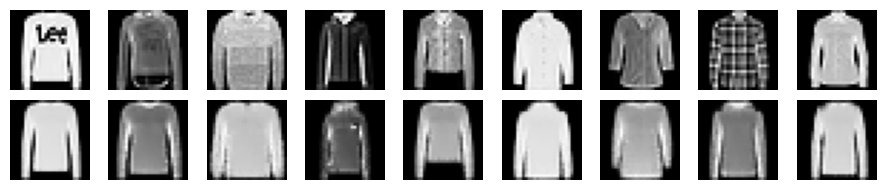

Anomaly Score sample: {'id': [0, 1, 2, 3, 4], 'label': [1, 0, 0, 0, 0], 'score': [0.3406029939651489, 0.370083212852478, 0.49759072065353394, 0.42443394660949707, 0.23748332262039185]}
AUROC: 0.7153
Optimal threshold: 0.1887
Best accuracy: 0.7377
Final Accuracy: 0.7377


In [8]:
####################################
# 최적 hyperparameter (loss)로 모델 재학습 및 평가
####################################
best_loss_params = study_loss.best_trial.params

model = EnhancedMemAE_Arch(mem_dim=FIXED_ARCH_PARAMS["mem_dim"],
                           fea_dim=FIXED_ARCH_PARAMS["fea_dim"],
                           channel_mult=FIXED_ARCH_PARAMS["channel_mult"],
                           shrink_thres=0.0,
                           input_noise_std=FIXED_ARCH_PARAMS["input_noise_std"],
                           latent_noise_std=FIXED_ARCH_PARAMS["latent_noise_std"]).to(DEVICE)
global latent_center
latent_center = compute_latent_center(model, train_loader)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCH)

for epoch in range(1, EPOCH + 1):
    loss_epoch = train_attn(model, train_loader, optimizer, DEVICE, feature_extractor, best_loss_params)
    scheduler.step()
    print(f"Epoch {epoch} done.")

test_plot(model)
dic_loss = compute_anomaly_scores(model, test_loader, DEVICE, feature_extractor, best_loss_params, gamma=0.5, SELECT_NORMAL=SELECT_NORMAL)
print("Anomaly Score sample:", {k: dic_loss[k][:5] for k in dic_loss})

arr_label = np.array(dic_loss['label'])
arr_score = np.array(dic_loss['score'])
fpr, tpr, _ = roc_curve(arr_label, arr_score, pos_label=0)
roc_auc = auc(fpr, tpr)
print(f"AUROC: {roc_auc:.4f}")

thresholds = np.linspace(arr_score.min(), arr_score.max(), num=300)
results = []
for thresh in thresholds:
    preds = np.where(arr_score > thresh, 0, 1)
    acc = accuracy_score(arr_label, preds)
    results.append({'threshold': thresh, 'accuracy': acc})
thresh_df = pd.DataFrame(results)
best_idx = thresh_df['accuracy'].idxmax()
optimal_threshold = thresh_df.loc[best_idx, 'threshold']
best_accuracy = thresh_df.loc[best_idx, 'accuracy']
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Best accuracy: {best_accuracy:.4f}")

df = pd.DataFrame.from_dict(dic_loss)
df['normal'] = np.where(df["score"] > optimal_threshold, 0, 1)
y_true = df['label'].astype(int)
y_pred = df['normal'].astype(int)
final_acc = accuracy_score(y_true, y_pred)
print(f"Final Accuracy: {final_acc:.4f}")


Step 0, Loss: 0.9973
Step 600, Loss: 0.5277
Step 1200, Loss: 0.5031
Epoch 1 done.
Step 0, Loss: 0.7440
Step 600, Loss: 0.5153
Step 1200, Loss: 0.5846
Epoch 2 done.
Step 0, Loss: 0.5217
Step 600, Loss: 0.5461
Step 1200, Loss: 0.5843
Epoch 3 done.
Step 0, Loss: 0.5318
Step 600, Loss: 0.5110
Step 1200, Loss: 0.4273
Epoch 4 done.
Step 0, Loss: 0.5433
Step 600, Loss: 0.4979
Step 1200, Loss: 0.4565
Epoch 5 done.
Step 0, Loss: 0.4175
Step 600, Loss: 0.4501
Step 1200, Loss: 0.3030
Epoch 6 done.
Step 0, Loss: 0.3845
Step 600, Loss: 0.2612
Step 1200, Loss: 0.2817
Epoch 7 done.
Step 0, Loss: 0.4857
Step 600, Loss: 0.3701
Step 1200, Loss: 0.3226
Epoch 8 done.
Step 0, Loss: 0.3163
Step 600, Loss: 0.2816
Step 1200, Loss: 0.2695
Epoch 9 done.
Step 0, Loss: 0.2777
Step 600, Loss: 0.3415
Step 1200, Loss: 0.4450
Epoch 10 done.


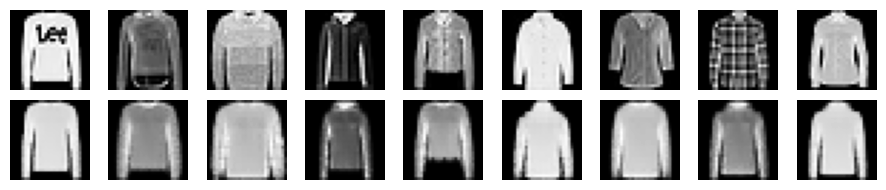

Anomaly Score sample: {'id': [0, 1, 2, 3, 4], 'label': [1, 0, 0, 0, 0], 'score': [0.3524288237094879, 0.48546266555786133, 0.5373427271842957, 0.4810965359210968, 0.29605674743652344]}
AUROC: 0.6971
Optimal threshold: 0.2377
Best accuracy: 0.7333
Final Accuracy: 0.7333


In [22]:
seed_everything(42)
best_loss_params = {
    "w_edge": 0.1987270059423681,
    "w_ms_ssim": 1.5802857225639666,
    'w_perc': 0,
    'w_latent': 0.012319939418114049,
    "sigma": 4.394633936788146

# Best Loss Hyperparameters:
#   Accuracy: 0.7433
#     w_edge: 0.1987270059423681
#     w_ms_ssim: 1.5802857225639666
#     w_latent: 0.012319939418114049
#     sigma: 4.394633936788146
    
    # "w_edge": 0.18325257964926397,
    # "w_ms_ssim": 1.5795542149013333,
    # 'w_perc': 1.586252813229824,
    # 'w_latent': 0.01308397348116461,

}

model = EnhancedMemAE_Arch(mem_dim=FIXED_ARCH_PARAMS["mem_dim"],
                           fea_dim=FIXED_ARCH_PARAMS["fea_dim"],
                           channel_mult=FIXED_ARCH_PARAMS["channel_mult"],
                           shrink_thres=0.0,
                           input_noise_std=FIXED_ARCH_PARAMS["input_noise_std"],
                           latent_noise_std=FIXED_ARCH_PARAMS["latent_noise_std"]).to(DEVICE)
global latent_center
latent_center = torch.full((FIXED_ARCH_PARAMS["fea_dim"],), 0.5, device=DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCH)

for epoch in range(1, EPOCH + 1):
    loss_epoch = train_attn(model, train_loader, optimizer, DEVICE, feature_extractor, best_loss_params)
    scheduler.step()
    print(f"Epoch {epoch} done.")

test_plot(model)
dic_loss = compute_anomaly_scores(model, test_loader, DEVICE, feature_extractor, best_loss_params, gamma=0.5, SELECT_NORMAL=SELECT_NORMAL)
print("Anomaly Score sample:", {k: dic_loss[k][:5] for k in dic_loss})

arr_label = np.array(dic_loss['label'])
arr_score = np.array(dic_loss['score'])
fpr, tpr, _ = roc_curve(arr_label, arr_score, pos_label=0)
roc_auc = auc(fpr, tpr)
print(f"AUROC: {roc_auc:.4f}")

thresholds = np.linspace(arr_score.min(), arr_score.max(), num=300)
results = []
for thresh in thresholds:
    preds = np.where(arr_score > thresh, 0, 1)
    acc = accuracy_score(arr_label, preds)
    results.append({'threshold': thresh, 'accuracy': acc})
thresh_df = pd.DataFrame(results)
best_idx = thresh_df['accuracy'].idxmax()
optimal_threshold = thresh_df.loc[best_idx, 'threshold']
best_accuracy = thresh_df.loc[best_idx, 'accuracy']
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Best accuracy: {best_accuracy:.4f}")

df = pd.DataFrame.from_dict(dic_loss)
df['normal'] = np.where(df["score"] > optimal_threshold, 0, 1)
y_true = df['label'].astype(int)
y_pred = df['normal'].astype(int)
final_acc = accuracy_score(y_true, y_pred)
print(f"Final Accuracy: {final_acc:.4f}")



[Experiment] baseline...
Step 0, Loss: 1.0619
Step 600, Loss: 0.7644
Step 1200, Loss: 0.5509
Step 0, Loss: 0.4932
Step 600, Loss: 0.4576
Step 1200, Loss: 0.3166
Step 0, Loss: 0.2987
Step 600, Loss: 0.3873
Step 1200, Loss: 0.2821
Step 0, Loss: 0.3941
Step 600, Loss: 0.3042
Step 1200, Loss: 0.3280
Step 0, Loss: 0.3377
Step 600, Loss: 0.3525
Step 1200, Loss: 0.2864
Step 0, Loss: 0.2797
Step 600, Loss: 0.4250
Step 1200, Loss: 0.2312
Step 0, Loss: 0.2623
Step 600, Loss: 0.2129
Step 1200, Loss: 0.3049
Step 0, Loss: 0.3391
Step 600, Loss: 0.2263
Step 1200, Loss: 0.2956
Step 0, Loss: 0.3037
Step 600, Loss: 0.2933
Step 1200, Loss: 0.3695
Step 0, Loss: 0.4391
Step 600, Loss: 0.3154
Step 1200, Loss: 0.2366
baseline AUROC: 0.7233

[Experiment] no_edge...
Step 0, Loss: 0.7148
Step 600, Loss: 0.3327
Step 1200, Loss: 0.2633
Step 0, Loss: 0.2267
Step 600, Loss: 0.1894
Step 1200, Loss: 0.2520
Step 0, Loss: 0.1586
Step 600, Loss: 0.2025
Step 1200, Loss: 0.2417
Step 0, Loss: 0.1779
Step 600, Loss: 0.193

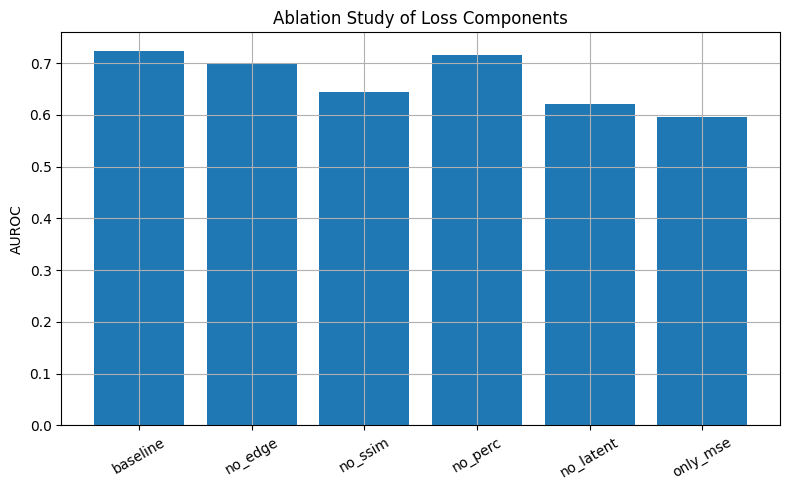

In [9]:
# ✅ Ablation 실험용 구성 추가
ablation_configs = {
    'baseline':  {'w_edge': 0.1810292247147901,
                  'w_ms_ssim': 1.5879639408647979,
                  'w_perc': 1.5329770563201688,
                  'w_latent': 0.007123391106782761,
                  'sigma': 2.7272998688284025},
    'no_edge':   {'w_edge': 0,
                  'w_ms_ssim': 1.5879639408647979,
                  'w_perc': 1.5329770563201688,
                  'w_latent': 0.007123391106782761,
                  'sigma': 2.7272998688284025},
    'no_ssim':   {'w_edge': 0.1810292247147901,
                  'w_ms_ssim': 0,
                  'w_perc': 1.5329770563201688,
                  'w_latent': 0.007123391106782761,
                  'sigma': 2.7272998688284025},
    'no_perc':   {'w_edge': 0.1810292247147901,
                  'w_ms_ssim': 1.5879639408647979,
                  'w_perc': 0,
                  'w_latent': 0.007123391106782761,
                  'sigma': 2.7272998688284025},
    'no_latent': {'w_edge': 0.1810292247147901,
                  'w_ms_ssim': 1.5879639408647979,
                  'w_perc': 1.5329770563201688,
                  'w_latent': 0,
                  'sigma': 2.7272998688284025},
    'only_mse':  {'w_edge': 0,
                  'w_ms_ssim': 0,
                  'w_perc': 0,
                  'w_latent': 0,
                  'sigma': 2.7272998688284025},
}


ablation_results = {}

for config_name, loss_params in ablation_configs.items():
    print(f"\n[Experiment] {config_name}...")

    model = EnhancedMemAE_Arch(mem_dim=FIXED_ARCH_PARAMS["mem_dim"],
                               fea_dim=FIXED_ARCH_PARAMS["fea_dim"],
                               channel_mult=FIXED_ARCH_PARAMS["channel_mult"],
                               shrink_thres=0.0,
                               input_noise_std=FIXED_ARCH_PARAMS["input_noise_std"],
                               latent_noise_std=FIXED_ARCH_PARAMS["latent_noise_std"]).to(DEVICE)

    latent_center = compute_latent_center(model, train_loader)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCH)

    for epoch in range(1, EPOCH + 1):
        train_attn(model, train_loader, optimizer, DEVICE, feature_extractor, loss_params)
        scheduler.step()

    dic_loss = compute_anomaly_scores(model, test_loader, DEVICE, feature_extractor, loss_params, gamma=0.5, SELECT_NORMAL=SELECT_NORMAL)
    arr_label = np.array(dic_loss['label'])
    arr_score = np.array(dic_loss['score'])
    fpr, tpr, _ = roc_curve(arr_label, arr_score, pos_label=0)
    roc_auc = auc(fpr, tpr)

    ablation_results[config_name] = roc_auc
    print(f"{config_name} AUROC: {roc_auc:.4f}")

# 결과 출력
print("\n[Final AUROC Comparison]")
for k, v in ablation_results.items():
    print(f"{k}: AUROC = {v:.4f}")

# 시각화 (선택)
plt.figure(figsize=(8,5))
plt.bar(ablation_results.keys(), ablation_results.values())
plt.xticks(rotation=30)
plt.ylabel('AUROC')
plt.title('Ablation Study of Loss Components')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
순번 | 수정 항목 | 내용 | 적용 위치 / 예시
1️⃣ | 중심 가중치 MSE 개선 | weighted_mse() 함수 → sigma 인자를 받는 weighted_mse_with_sigma()로 변경 | def weighted_mse_with_sigma(pred, target, sigma)
2️⃣ | improved_attn_loss() 수정 | sigma를 외부 인자로 받아서 weighted_mse_with_sigma()에 전달 | improved_attn_loss(..., sigma=loss_params['sigma'])
3️⃣ | Optuna 튜닝에 sigma 추가 | trial.suggest_float("sigma", 2.0, 6.0)으로 탐색 대상에 포함 | objective_loss(trial) 내부
4️⃣ | loss_params 딕셔너리에 sigma 포함 | 튜닝 중인 loss 파라미터와 함께 sigma도 포함 | loss_params = { ..., 'sigma': sigma }
5️⃣ | 모든 loss 계산 함수에 sigma 전달 반영 | train_attn(), compute_anomaly_scores() 등에서 sigma=loss_params['sigma'] 추가 | loss 호출 부분
6️⃣ | latent center 고정값 제거 | 기존 torch.full((fea_dim,), 0.5) 제거 | latent_center = torch.full(...) 줄 삭제
7️⃣ | compute_latent_center() 함수 도입 | 정상 학습 데이터를 모델에 통과시켜 평균 latent 벡터 계산 | def compute_latent_center(model, train_loader)
8️⃣ | 학습 전에 중심 계산하도록 구조 수정 | 모델 정의 후 latent_center = compute_latent_center(...) 호출 | 학습 루프 시작 전
9️⃣ | loss 계산에 latent_center 자동 반영 | 개선된 latent_center는 improved_attn_loss() 내부에서 사용 | lat_loss = ((z - latent_center)**2).mean()

📌 성능 개선 목적별 분류
🎯 중심 가중치 개선 (sigma 튜닝)
데이터 특성에 따라 중심 영역의 중요도를 조절할 수 있게 되어
loss의 민감도 제어 → 성능 안정성 향상

🎯 latent 기준점 개선 (latent_center)
임의의 고정값 대신 실제 정상 데이터 평균으로 설정
→ 정확한 이상 판단 기준 확보, latent loss 신뢰도 향상
ㅣ
시도해볼만한 사항
loss parameter 종류 줄이기 / 효과가 가장 큰 놈들만 남기고 삭제

[I 2025-04-16 04:29:43,959] Trial 6 finished with value: 0.746 and parameters: {'w_edge': 0.2028034992108518, 'w_ms_ssim': 1.5140703845572054, 'w_latent': 0.006996737821583597, 'sigma': 4.056937753654447}. Best is trial 6 with value: 0.746.
Trial 6: Loss HP ->  w_edge=0.2028, w_ms_ssim=1.5141, w_latent=0.0070 | Accuracy = 0.7460